# Annotation Tutorial

**NB**: please refer to the scVI-dev notebook for introduction of the scVI package.

In this notebook, we investigate how semi-supervised learning combined with the probabilistic modelling of latent variables in scVI can help address the annotation problem.

The annotation problem consists in labelling cells, ie. **inferring their cell types**, knowing only a part of the labels.


In [1]:
cd ~/scVI

/home/ubuntu/scVI


# Annotating one dataset from another

We will perform the annotation task on three sets of datasets:

- Synthetic data: UMI / nonUMI

- Macosko/Regev

- SCMAP datasets

The code needed is below.

Note that since some of these datasets are big (Macosko-Regev), you might need to launch the notebook once for each.

In [2]:
import numpy as np
import pandas as pd

from scvi.dataset import *
from scvi.dataset.BICCN import MacoskoDataset, RegevDataset
from scvi.dataset.scmap_datasets import MuraroDataset, BaronDataset, XinDataset, SegerstolpeDataset
from scvi.dataset.synthetic import SyntheticUMI, SyntheticNONUMI
from scvi.inference import *
from scvi.models import *

params = {
    'n_epoch_train_vae': 200,
    'lr_train_vae': 1e-3,
    'batch_size':128,
    'n_layers': 2,
    'n_hidden': 256,
    'nb_genes': 1000,
    'classifier_parameters': dict(),
    'weight_decay':1e-6,
    
    'n_epoch_train_scanvi': 200,
    'lr_train_scanvi': 1e-4,
    'classification_ratio': 10,
    'lr_classification': 1e-3,
    'save_t_sne_folder': 'figures/'
}

from scvi.benchmark import benchmark_scanvi

### Synthetic Data

File data/umi.loom already downloaded
Preprocessing dataset
Finished preprocessing dataset
File data/nonumi.loom already downloaded
Preprocessing dataset
Finished preprocessing dataset
SyntheticUMI->SyntheticNONUMI
Keeping 2000 genes
Downsampling from 2000 to 1000 genes
Maximum Accuracy :  1.0
training: 100%|██████████| 300/300 [18:06<00:00,  3.62s/it]
0.7005
training: 100%|██████████| 200/200 [29:07<00:00,  8.74s/it]
Acc for unlabelled is : 0.7702 +- 0.0084


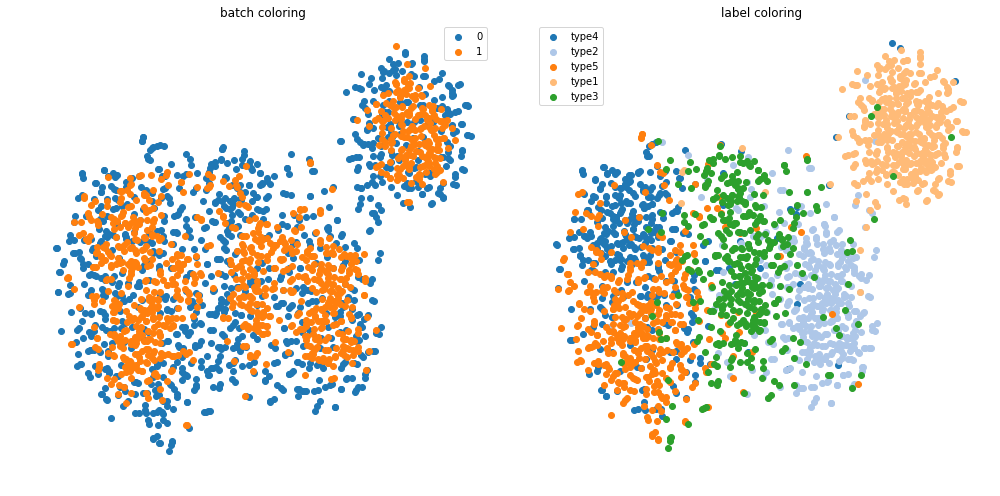

SyntheticNONUMI->SyntheticUMI
Keeping 2000 genes
Downsampling from 2000 to 1000 genes
Maximum Accuracy :  1.0
training: 100%|██████████| 300/300 [18:00<00:00,  3.60s/it]
0.72405
training: 100%|██████████| 200/200 [28:51<00:00,  8.66s/it]
Acc for unlabelled is : 0.7759 +- 0.0281


<Figure size 432x288 with 0 Axes>

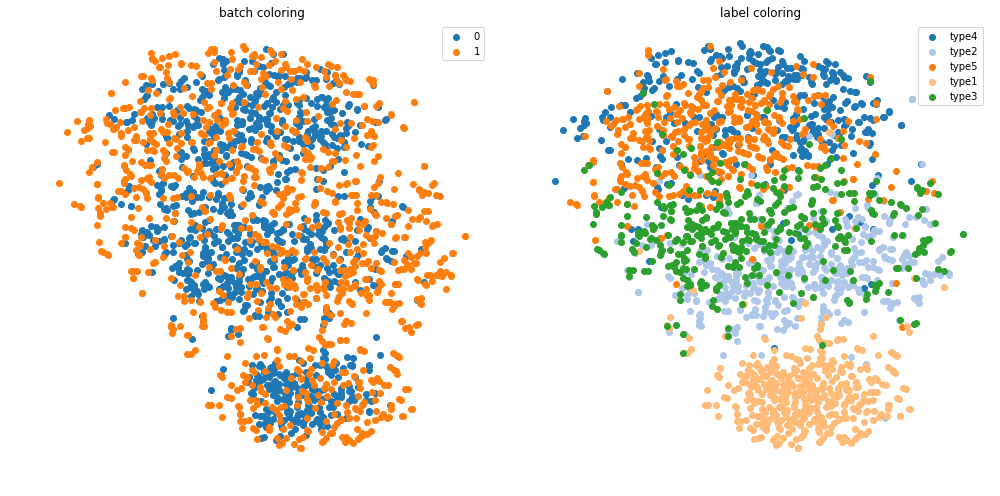

FileNotFoundError: [Errno 2] No such file or directory: 'figures/SyntheticNONUMI->SyntheticUMI.svg'

<Figure size 432x288 with 0 Axes>

In [3]:
results_umi_nonumi = pd.DataFrame(index=['UMI SCANVI', 'UMI SCMAP', 'NON-UMI SCANVI', 'NON-UMI SCMAP'],
                                  columns=['UMI', 'NON-UMI'])
synthetic_umi = SyntheticUMI()
synthetic_nonumi = SyntheticNONUMI()

params.update({
    'n_epoch_train_vae': 300, 
    'nb_genes': 1000,
    'n_epoch_train_scanvi': 200,
    'lr_train_scanvi': 1e-4
})


umi_to_nonumi = benchmark_scanvi(synthetic_umi, synthetic_nonumi, params)
nonumi_to_umi = benchmark_scanvi(synthetic_nonumi, synthetic_umi, params)

results_umi_nonumi['NON-UMI']['UMI SCANVI'] = umi_to_nonumi['acc']
results_umi_nonumi['UMI']['NON-UMI SCANVI'] = nonumi_to_umi['acc']

In [4]:
results_umi_nonumi

,UMI,NON-UMI
UMI SCANVI,NaN,NaN
UMI SCMAP,NaN,NaN
NON-UMI SCANVI,NaN,NaN
NON-UMI SCMAP,NaN,NaN


### Macosko Regev

In [ ]:
results_macosko_regev = pd.DataFrame(index=['Macosko SCANVI', 'Macosko SCMAP', 'Regev SCANVI', 'Regev SCMAP'],
                                   columns=['Macosko', 'Regev'])
macosko = MacoskoDataset()
regev = RegevDataset()

macosko_to_regev = benchmark_scanvi(macosko, regev, params, max_acc=False)
regev_to_macosko = benchmark_scanvi(regev, macosko, params, max_acc=False)

results_macosko_regev['Regev']['Macosko SCANVI'] = macosko_to_regev['acc']
results_macosko_regev['Macosko']['Regev SCANVI'] = regev_to_macosko['acc']

results_macosko_regev['Regev']['Macosko SCMAP'] = 0.911
results_macosko_regev['Macosko']['Regev SCMAP'] = 0.870

In [ ]:
results_macosko_regev

### SCMAP datasets

#### All the one-to-one prediction

In [4]:
datasets_name = ['Xin', 'Segerstolpe','Muraro','Baron']
index = ['%s %s'%(s,algo) for s in datasets_name for algo in ['SCMAP','SCANVI']]
results_scmap = pd.DataFrame(index=index,columns=datasets_name)

import pickle
precomputed_results_scmap = pickle.load(open('4d-scmap-results.pickle', 'rb'))
n_features_scmap = 300 # or 100 - 500
for i in range(4):
    for j in range(4):
        if j==i: continue
        results_scmap[datasets_name[j]][datasets_name[i]+' SCMAP']= precomputed_results_scmap[300][(i,)][j]

results_scmap

,Xin,Segerstolpe,Muraro,Baron
Xin SCMAP,NaN,0.661385,0.698965,0.655036
Xin SCANVI,NaN,NaN,NaN,NaN
Segerstolpe SCMAP,0.989946,NaN,0.916588,0.878282
Segerstolpe SCANVI,NaN,NaN,NaN,NaN
Muraro SCMAP,0.977882,0.943213,NaN,0.881316
Muraro SCANVI,NaN,NaN,NaN,NaN
Baron SCMAP,0.984584,0.903509,0.904807,NaN
Baron SCANVI,NaN,NaN,NaN,NaN


File data/xin.loom already downloaded
Preprocessing dataset
Finished preprocessing dataset
File data/segerstolpe.loom already downloaded
Preprocessing dataset
Finished preprocessing dataset
File data/muraro.loom already downloaded
Preprocessing dataset
Finished preprocessing dataset
File data/baron.loom already downloaded
Preprocessing dataset
Finished preprocessing dataset
Keeping 16459 genes
Downsampling from 39851 to 39687 genes
Downsampling from 25525 to 25280 genes
Downsampling from 19127 to 19127 genes
Downsampling from 20125 to 20123 genes
XinDataset->SegerstolpeDataset
Keeping 23642 genes
Downsampling from 23642 to 300 genes
Maximum Accuracy :  0.67728531856
training: 100%|██████████| 800/800 [04:11<00:00,  3.19it/s]
0.985511208311
training: 100%|██████████| 200/200 [03:01<00:00,  1.10it/s]


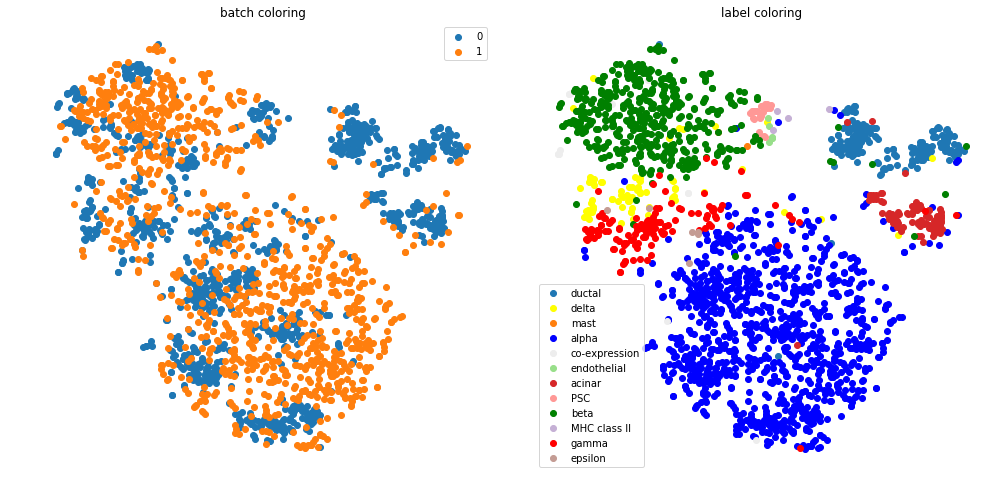

XinDataset->MuraroDataset
Keeping 18548 genes
Downsampling from 18548 to 300 genes
Maximum Accuracy :  0.73232799246
training: 100%|██████████| 800/800 [04:06<00:00,  3.24it/s]
1.0
training:  91%|█████████ | 182/200 [02:40<00:15,  1.13it/s]

In [ ]:
datasets = [XinDataset(), SegerstolpeDataset(), MuraroDataset(), BaronDataset()]
dataset = GeneExpressionDataset.concat_datasets(*datasets)
for dataset in datasets:
    dataset.filter_genes(gene_names_ref=dataset.gene_names)
    
for dataset in datasets:
    dataset.subsample_genes(subset_genes=(dataset.X.max(axis=0) <= 2500).ravel())

params.update({
    'n_epoch_train_vae': 800,
    'nb_genes': 300,
    'n_epoch_train_scanvi': 200,
    'lr_train_scanvi': 1e-3,
})

results = dict()

for source in range(4):
    targets = list(range(4))
    targets.remove(source)
    if source not in results:
        results[source] = dict()
    for target in targets:
        results[source][target] = benchmark_scanvi(datasets[source], datasets[target], params)
        results_scmap[datasets_name[j]][datasets_name[i]+' SCANVI'] = \
            results[source][target]['acc']

#### Using two datasets as input improves our annotation accuracy score

In [ ]:
sources = (0, 1)
target = 2

results[sources] = dict()
results_0_1_to_2 = run_scanvi(datasets[target], [datasets[source] for source in sources], params)
results[sources][target] = results_0_1_to_2

# Annotating partially labelled datasets

In [ ]:
# TODO: Part II - predicting a partially labelled dataset (already done but include other results)

# Cortex

# Purified

# Hierarchical prediction with macosko regev